In [17]:
import pandas as pd

# Replace 'path_to_your_dataset.csv' with the actual file path
file_path = '/kaggle/input/online-retail-ii/online_retail_II.csv'
data = pd.read_csv(file_path, parse_dates=['InvoiceDate'], encoding='latin1')


/tmp/ipykernel_33/1525427421.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(file_path, parse_dates=['InvoiceDate'], encoding='latin1')


In [18]:
# Remove rows with missing CustomerID
data = data.dropna(subset=['Customer ID'])

# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


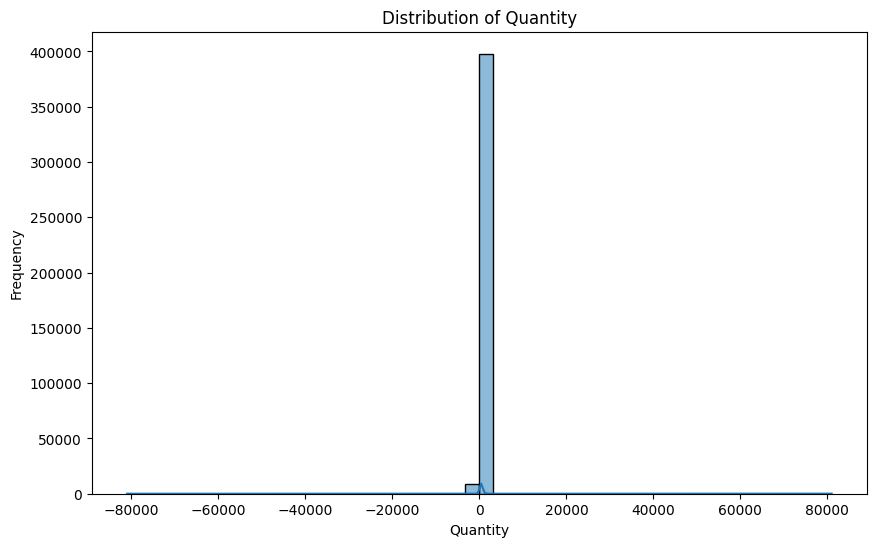

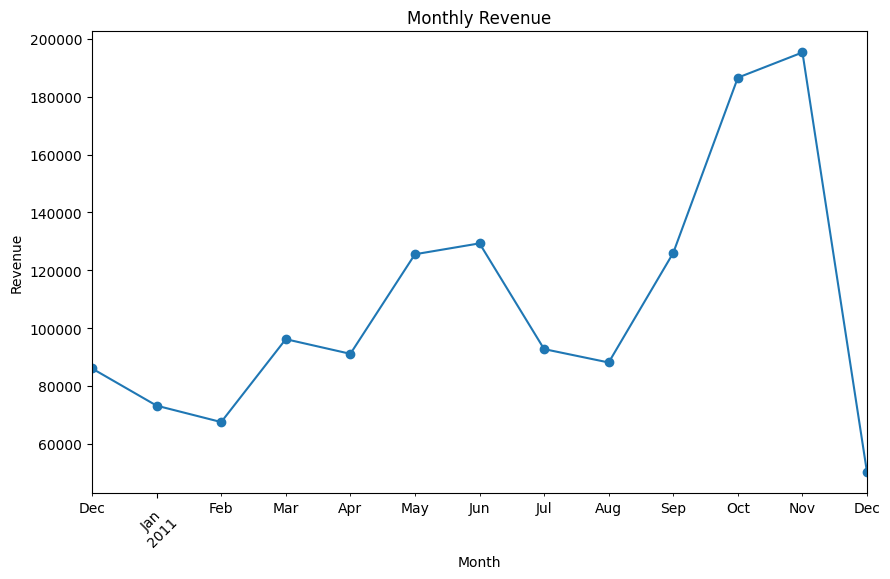

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of key variables
plt.figure(figsize=(10, 6))
sns.histplot(data['Quantity'], bins=50, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

# Visualize customer spending patterns over time
data['InvoiceYearMonth'] = data['InvoiceDate'].dt.to_period('M')
monthly_revenue = data.groupby('InvoiceYearMonth')['Price'].sum()

plt.figure(figsize=(10, 6))
monthly_revenue.plot(kind='line', marker='o')
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()


In [20]:
from sklearn.cluster import KMeans

# RFM Analysis
rfm_data = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (data['InvoiceDate'].max() - x.max()).days,
    'Invoice': 'nunique',
    'Price': 'sum'
}).reset_index()

rfm_data.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Standardize the variables
rfm_scaled = (rfm_data[['Recency', 'Frequency', 'Monetary']] - rfm_data[['Recency', 'Frequency', 'Monetary']].mean()) / rfm_data[['Recency', 'Frequency', 'Monetary']].std()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_scaled)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
from mlxtend.frequent_patterns import apriori, association_rules

# Create basket of items (transactions)
basket = data.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')

# Convert quantities to binary values
basket_encoded = basket.applymap(lambda x: 1 if x > 0 else 0)

# Find frequent itemsets
frequent_itemsets = apriori(basket_encoded, min_support=0.02, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)


/tmp/ipykernel_33/2728109284.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encoded = basket.applymap(lambda x: 1 if x > 0 else 0)
/opt/conda/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [22]:
# Print customer segments
print("Customer Segments:")
print(rfm_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}))

# Print association rules
print("\nAssociation Rules:")
print(rules.head())


Customer Segments:
            Recency   Frequency      Monetary
Cluster                                      
0         41.649679    4.477244    262.170043
1         39.142857  109.428571  28197.814286
2        248.378731    1.809701     98.705999
3          9.104046   31.878613   1657.051445

Association Rules:
                            antecedents                           consequents  \
0          (ALARM CLOCK BAKELIKE GREEN)           (ALARM CLOCK BAKELIKE RED )   
1           (ALARM CLOCK BAKELIKE RED )          (ALARM CLOCK BAKELIKE GREEN)   
2  (GARDENERS KNEELING PAD CUP OF TEA )   (GARDENERS KNEELING PAD KEEP CALM )   
3   (GARDENERS KNEELING PAD KEEP CALM )  (GARDENERS KNEELING PAD CUP OF TEA )   
4      (PINK REGENCY TEACUP AND SAUCER)     (GREEN REGENCY TEACUP AND SAUCER)   

   antecedent support  consequent support   support  confidence       lift  \
0            0.035557            0.039522  0.023885    0.671736  16.996386   
1            0.039522            0.035557 